# Langgraph with Deepseek R1
Using vllm to serve DeepSeek R1 distillation of Qwan 2.5 32b with tool calling like this
Start the server with tool calling enabled. This example uses Meta’s Llama 3.1 8B model, so we need to use the llama3 tool calling chat template from the vLLM examples directory:

vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-32B \
    --enable-auto-tool-choice \
    --tool-call-parser llama3_json \
    --chat-template examples/tool_chat_template_llama3.1_json.jinja


In [2]:
#!pip install -q openai langchain langgraph langchain-openai tavily-python  langchain_community langchainhub langchain_experimental arxiv pygraphviz --upgrade

In [7]:
from langchain import hub
from langchain_experimental.utilities import PythonREPL
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_deepseek import ChatDeepSeek
from langchain.agents import create_react_agent, load_tools
from langchain.agents import Tool
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from openai import OpenAI
#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
# Apply for API Key in https://platform.deepseek.com/api_keys
#DEEPSEEK_API_KEY = user_secrets.get_secret("DEEPSEEK_API_KEY")
DEEPSEEK_API_KEY = "ollama"
#TAVILY_API_KEY = user_secrets.get_secret("TAVILY_API_KEY")
import os, sys
TAVILY_API_KEY = os.environ["TAVILY_API_KEY"] = os.getenv("tavily_api_token")
LOCAL_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-70B"
LOCAL_MODEL2="/home/alfred/codes/deepseek/scripts/data/Qwen2.5-1.5B-Open-R1-Distill"
#LOCAL_MODEL = "DeepSeek R1 Distill Llama 70B"
#LOCAL_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Llama-70B"
LOCAL_API_URL = "http://agent.cavatar.info:8080/v1"
LOCAL_API_URL2 = "http://infs.cavatar.info:8080/v1"

## Create agent and build graph

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
        
class Agent:

    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_r1)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_r1(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

### Bedrock and local DeepSeek models

In [8]:
import boto3
from langchain_aws import BedrockLLM, ChatBedrock, ChatBedrockConverse
#from langchain_community.llms import Bedrock

aws_region = 'us-west-2'
bedrock_client = boto3.client("bedrock-runtime", region_name=aws_region)
model_id_c3 = 'anthropic.claude-3-haiku-20240307-v1:0'
model_id_haiku35 = 'anthropic.claude-3-5-haiku-20241022-v1:0'
model_id_nova = 'us.amazon.nova-lite-v1:0'
model_id_r1 = "arn:aws:bedrock:us-west-2:976939723775:imported-model/0io5ycterxsq" #"arn:aws:bedrock:us-west-2:976939723775:imported-model/w7jgne12nix8"


model_id = model_id_r1



inference_modifier = {
    "max_tokens": 2048,
    "temperature": 0.01,
    "top_k": 50,
    "top_p": 0.95,
    "stop_sequences": ["\n\n\nHuman"],
}

llm_chat = ChatBedrock(
    model_id=model_id,
    client=bedrock_client,
    model_kwargs=inference_modifier,
    region_name=aws_region,
    provider="llama"
)  
llm_chat_conv = ChatBedrockConverse(
    model=model_id,
    client=bedrock_client,
    temperature=0.01,
    max_tokens=2048,
    region_name=aws_region,
)
'''
llm_br = BedrockLLM(
    model_id=model_id,
    client=bedrock_client,
    model_kwargs={"temperature": 0.1, "max_gen_len":1024},
)  
'''
## Model 
llm_local = ChatOpenAI(
    model=LOCAL_MODEL, 
    api_key=DEEPSEEK_API_KEY, 
    base_url=LOCAL_API_URL,
    max_tokens=1024,
    temperature=0.2
)

llm_langchain_local = ChatDeepSeek(
    model=LOCAL_MODEL, 
    api_key=DEEPSEEK_API_KEY, 
    base_url=LOCAL_API_URL,
    max_tokens=1024,
    temperature=0.2,
    timeout=None,
    max_retries=2,
)

### Langchain with DeepSeek

In [4]:
from langchain_deepseek import ChatDeepSeek
from langchain_community.tools import TavilySearchResults

#### Direct invokation

In [9]:
messages = [
    (
        "system",
        "You are a seasoned mathematician.",
    ),
    ("human", "Use any numbers from 0 to 9 to construct 2 equations which equal to 2025?"),
]
ai_msg = llm_langchain_local.invoke(messages)
ai_msg.content

"<think>\nFirst, I need to create two equations using numbers from 0 to 9 that both equal 2025. I'll start by considering the number 2025 and think about how it can be expressed as a product of two numbers. \n\nI notice that 2025 is a perfect square, specifically 45 squared. This gives me an idea for the first equation. I can use 45 multiplied by 45 to get 2025. \n\nNext, I want to create a second equation that also equals 2025 but uses different numbers. I'll consider other factors of 2025. Breaking it down, 2025 divided by 25 is 81. So, I can use 25 multiplied by 81 to achieve the desired result.\n\nNow, I'll verify both equations to ensure they are correct:\n- 45 × 45 equals 2025.\n- 25 × 81 also equals 2025.\n\nBoth equations meet the requirement of using numbers from 0 to 9 and equaling 2025.\n</think>\n\nCertainly! Let's construct two equations using numbers from 0 to 9 that both equal 2025.\n\n### Equation 1:\n\\[ 45 \\times 45 = 2025 \\]\n\n**Explanation:**\n- **45** is a numbe

#### Langcghain Deepseek stream

In [13]:
stream = llm_langchain_local.stream(messages)
full = next(stream)
for chunk in stream:
    full += chunk
    print(chunk.content, end='')
full.content

<think>
First, I need to create two equations using numbers from 0 to 9 that both equal 2025. I'll start by considering the number 2025 and think about how it can be expressed as a product of two numbers. 

I notice that 2025 is a perfect square, specifically 45 squared. This gives me an initial equation: 45 × 45 = 2025. However, I want to use a variety of digits, so I'll look for another combination.

Next, I'll explore other factors of 2025. Breaking it down, 2025 can be expressed as 25 × 81. Both 25 and 81 are squares of single-digit numbers (5 and 9, respectively), which fits well within the 0-9 range.

This gives me the second equation: 25 × 81 = 2025. 

I've successfully created two distinct equations using numbers from 0 to 9 that both equal 2025.
</think>

Certainly! Let's construct two equations using numbers from 0 to 9 that both equal 2025.

### Equation 1:
\[ 45 \times 45 = 2025 \]

### Equation 2:
\[ 25 \times 81 = 2025 \]

Both equations use numbers within the range of 0 

"<think>\nFirst, I need to create two equations using numbers from 0 to 9 that both equal 2025. I'll start by considering the number 2025 and think about how it can be expressed as a product of two numbers. \n\nI notice that 2025 is a perfect square, specifically 45 squared. This gives me an initial equation: 45 × 45 = 2025. However, I want to use a variety of digits, so I'll look for another combination.\n\nNext, I'll explore other factors of 2025. Breaking it down, 2025 can be expressed as 25 × 81. Both 25 and 81 are squares of single-digit numbers (5 and 9, respectively), which fits well within the 0-9 range.\n\nThis gives me the second equation: 25 × 81 = 2025. \n\nI've successfully created two distinct equations using numbers from 0 to 9 that both equal 2025.\n</think>\n\nCertainly! Let's construct two equations using numbers from 0 to 9 that both equal 2025.\n\n### Equation 1:\n\\[ 45 \\times 45 = 2025 \\]\n\n### Equation 2:\n\\[ 25 \\times 81 = 2025 \\]\n\nBoth equations use num

#### Langchain deepseek bind_tools

In [14]:
from pydantic import BaseModel, Field

class GetWeather(BaseModel):
    '''Get the current weather in a given location'''

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")

class GetPopulation(BaseModel):
    '''Get the current population in a given location'''

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")

llm_with_tools = llm_langchain_local.bind_tools([GetWeather, GetPopulation])
ai_msg = llm_with_tools.invoke("Which city is hotter today and which is bigger: LA or NY?")
ai_msg.tool_calls

NotImplementedError: 

#### With tool

In [15]:
import datetime
from langchain_core.prompts import ChatPromptTemplate

today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
    [
        ("system", f"You are a helpful assistant. The date today is {today}."),
        ("human", "{user_input}"),
        ("placeholder", "{messages}"),
    ]
)

tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)

# Direct invoke
tool.invoke({"query": "What happened at the last wimbledon"})

[{'url': 'https://www.nytimes.com/athletic/live-blogs/wimbledon-2024-live-updates-alcaraz-djokovic-mens-final-result/kJJdTKhOgkZo/mGpXBR2QIift/',
  'content': "Carlos Alcaraz beats Novak Djokovic to win the men's singles final In the 2023 final, Carlos Alcaraz won his first Wimbledon title, and only his second Grand Slam title, after beating Novak Djokovic in a five-set thriller on Centre Court. GO FURTHER Novak Djokovic and Carlos Alcaraz’s Wimbledon final is a duel of extraordinary quests Novak Djokovic set up a Wimbledon rematch with Carlos Alcaraz by beating Lorenzo Musetti, 6-4, 7-6, 6-3 on Centre Court on Friday, concluding his run to the final at the All England Club that started just 25 days after surgery on a torn meniscus in his right knee. GO FURTHER Novak Djokovic beats Lorenzo Musetti for Wimbledon final against Carlos Alcaraz"},
 {'url': 'https://www.nbcnews.com/news/sports/andy-murray-wimbledon-tennis-singles-draw-rcna159912',
  'content': "LONDON — Andy Murray, one of t

In [16]:
# specifying tool_choice will force the model to call this tool.
from langchain_community.retrievers import TavilySearchAPIRetriever

retriever = TavilySearchAPIRetriever(k=3)
retriever.invoke("what year was breath of the wild released?")

/home/alfred/anaconda3/envs/medf/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


[Document(metadata={'title': 'The Legend of Zelda: Breath of the Wild - Nintendo Switch Wiki', 'source': 'https://nintendo-switch.fandom.com/wiki/The_Legend_of_Zelda:_Breath_of_the_Wild', 'score': 0.78154784, 'images': []}, page_content='The Legend of Zelda: Breath of the Wild is an open world action-adventure game published by Nintendo for the Wii U and as a launch title for the Nintendo Switch, and was released worldwide on March 3, 2017. It is the nineteenth installment of the The Legend of Zelda series and the first to be developed with a HD resolution.'),
 Document(metadata={'title': 'The Legend of Zelda: Breath of the Wild - Wikipedia', 'source': 'https://en.wikipedia.org/wiki/The_Legend_of_Zelda:_Breath_of_the_Wild', 'score': 0.6052631, 'images': []}, page_content='Reviewers also commented on the unexpected permutations of interactions between Link, villagers, pets, and enemies,[129][130][131] many of which were shared widely on social media.[132] A tribute to former Nintendo pr

In [17]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

prompt = ChatPromptTemplate.from_template(
    """Answer the question based only on the context provided.

Context: {context}

Question: {question}"""
)
chain = (
    RunnablePassthrough.assign(context=(lambda x: x["question"]) | retriever)
    | prompt
    | llm_langchain_local
    | StrOutputParser()
)

In [41]:
question = "Do you think if there're any merits for counties to explicitly ban Deepseek and why?"
#chain.invoke({"question": question})

In [42]:
# Streamin
#async for text in chain.astream({"question": question}):
#    print(text, flush=True)

for chunk in chain.stream({"question": question}):
    print(chunk, end="", flush=True)

<think>
Okay, so I'm trying to figure out if there are any merits for counties to explicitly ban Deepseek and why. I don't know much about Deepseek, but from the context given, it seems like it's some kind of entity that counties might interact with. Let me go through the provided documents to see if I can find any clues.

The first document talks about why counties exist today, which is to serve the purposes of state government. It also mentions that county courthouses are located in a specific city, but that's probably not relevant here. It then discusses non-partisan candidates and what a stadium authority does. Hmm, not directly related to banning something like Deepseek, but it shows that counties handle various local matters.

The second document explains that county government powers are very limited. They can only pass regulations related to county affairs and can't go against state laws or interfere with local affairs of townships, cities, or villages. So, if a county wanted t

### Agent with toola nd langgraph using Tavily

In [24]:
from langchain_core.tools import tool

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
## Math
@tool
def multiply(x: float, y: float) -> float:
    """Multiply 'x' times 'y'."""
    return x * y

@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the 'y'."""
    return -1*(x**y)

@tool
def add(x: float, y: float) -> float:
    """Add 'x' and 'y'."""
    return x + y
    
## Search
search = TavilySearchResults(max_results=4)

## Tools 
tools = [multiply,exponentiate, add]

## Agent
agent = Agent(llm_local, tools, system=prompt)

### Direct call using sdk

In [12]:
os.getenv("deepseek_api_token")

In [68]:
from openai import OpenAI
import json, os
from langchain_core.tools import tool
from pydantic import BaseModel, Field


class GetWeather(BaseModel):
    """Get the current weather in a given location"""

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")

def get_weather(location: str, unit: str):
    return f"Getting the weather for {location} in {unit}..."
tool_functions = {"get_weather": get_weather}

weather_tools = [{
    "type": "function",
    "function": {
        "name": "get_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {"type": "string", "description": "City and state, e.g., 'San Francisco, CA'"},
                "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]}
            },
            "required": ["location", "unit"]
        }
    }
}]

messages = [
    (
        "system",
        "You are a helpful assistant who can answer question accurately and truthfully",
    ),
    ("human", "Two ships are sailing in the sea on the two sides of a lighthouse. The angle of elevation of the top of the lighthouse is observed from the ships are 30º and 45º respectively. If the lighthouse is 100 m high, what is the distance between the two ships in decimal number?"),
]

  
#response = llm_local.bind_tools([GetWeather]).invoke(messages)
response = llm_local.invoke(messages)
response

AIMessage(content="<think>\nFirst, I need to visualize the problem. There's a lighthouse that's 100 meters high, and two ships are positioned on opposite sides of it. From each ship, the angle of elevation to the top of the lighthouse is 30 degrees and 45 degrees, respectively.\n\nI'll start by considering the first ship, which has an angle of elevation of 30 degrees. Using trigonometry, specifically the tangent function, I can find the distance from this ship to the base of the lighthouse. The tangent of 30 degrees is equal to the height of the lighthouse divided by the distance from the ship to the lighthouse. Solving for the distance gives me 100 meters divided by the tangent of 30 degrees, which is approximately 100 divided by 0.5774, resulting in about 173.2 meters.\n\nNext, I'll do the same for the second ship with a 45-degree angle of elevation. Again, using the tangent function, the tangent of 45 degrees is equal to the height of the lighthouse divided by the distance from the 

## Alternative way to call ocal deepseek r1

# simulate an API that can be called
def get_current_weather(city: str, state: str, unit: 'str'):
    return (f"The weather in {city}, {state} is 85 degrees {unit}. It is "
            "partly cloudly, with highs in the 90's.")

tool_funtions = {"get_current_weather": get_current_weather}

tools = [{
    "type": "function",
    "function": {
        "name": "get_current_weather",
        "description": "Get the current weather in a given location",
        "parameters": {
            "type": "object",
            "properties": {
                "city": {
                    "type":
                    "string",
                    "description":
                    "The city to find the weather for, e.g. 'San Francisco'"
                },
                "state": {
                    "type":
                    "string",
                    "description":
                    "the two-letter abbreviation for the state that the city is"
                    " in, e.g. 'CA' which would mean 'California'"
                },
                "unit": {
                    "type": "string",
                    "description": "The unit to fetch the temperature in",
                    "enum": ["celsius", "fahrenheit"]
                }
            },
            "required": ["city", "state", "unit"]
        }
    }
}]

### Use OpenAI's OpenAI

prompt2 = "What is the current weather in SF?"
r1_client = OpenAI(
    api_key=DEEPSEEK_API_KEY,
    base_url=LOCAL_API_URL,
)

chat_response = r1_client.chat.completions.create(
    model=LOCAL_MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant. Please answer the user question accurately and truthfully. Also please make sure to think carefully before answering"},
        {"role": "user", "content": prompt2},
    ],
    stream=False,
    temperature=0.0,
    max_tokens=2048,
    top_p=0.95
)
usages = f'Completion_toekns: {chat_response.usage.completion_tokens}, Prompt_tokens: {chat_response.usage.prompt_tokens},  Total_tokens:{chat_response.usage.total_tokens}'
chat_response.choices[0].message.content, usages

### Use Langgraph's ChatOpenAI

In [36]:
messages = [
    SystemMessage(
        content="You are a smart assistant. Use the tools to solve a user problem. \
You are allowed to make multiple calls (either together or in sequence). \
Think carefully before answering the question to make sure the result is correct."
    ),
    HumanMessage(
        content="WHat was the results of Trump's latest phone call with Canada's priminster?" #"what is (3*3.45+5**2.435)?"
    ),
]
#repsone = llm_local.invoke(messages)
#response = llm_local.bind_tools(tools, tool_choice="auto").invoke(messages)
response = llm_local.bind_tools([search]).invoke(messages)
response

AIMessage(content='<think>\nOkay, so the user is asking about the results of Trump\'s latest phone call with Canada\'s prime minister. Hmm, first off, I need to make sure I have the correct information. Wait, Trump isn\'t the current president anymore; he was the 45th president, and now Biden is in office. So, maybe the user made a mistake and meant Biden instead of Trump? Or perhaps they\'re referring to a past call during Trump\'s presidency?\n\nAlso, the user wrote "priminster" which I think is a typo for "prime minister." Canada\'s prime minister is Justin Trudeau. So, I should consider that correction in my response.\n\nI don\'t have access to real-time information, so I can\'t provide the latest updates. But I can suggest where the user might find this information. They can check reliable news sources or official government websites for any recent statements or press releases about such calls.\n\nI should make sure to clarify the potential mix-up between Trump and Biden and offer

### Using langchain tools

In [37]:
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain import hub

instructions = """You are an seasoned assistant.Please think and answer user question truefully."""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)

agent = create_openai_functions_agent(llm_local, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
)

/home/alfred/anaconda3/envs/medf/lib/python3.11/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [38]:
agent_executor

AgentExecutor(verbose=True, agent=RunnableAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_function_messages(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='H

### Using Langchain 

In [47]:
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

retriever = TavilySearchAPIRetriever(k=5)

query = "what is AMZN stock closing price today?"

prompt = ChatPromptTemplate.from_template(
        """Answer the question based only on the context provided.
    
    Context: {context}
    
    Question: {question}"""
    )


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm_chat_conv
    | StrOutputParser()
)
response = chain.invoke(query)
response

"I apologize, but I cannot find the specific closing price for AMZN stock in the provided context. While the context contains various financial information and news about Amazon, it does not include today's specific stock closing price."

## Tool
tool = TavilySearchResults(max_results=4)

## Agent
agent2 = Agent(llm, [tool], system=prompt)

In [ ]:
## Graph display

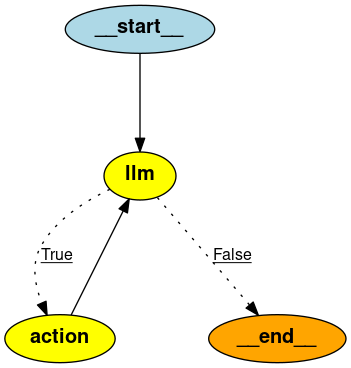

In [25]:
from IPython.display import Image

Image(agent.graph.get_graph().draw_png())

In [26]:
## Analyze

In [27]:
question = "what's 3*3.12 plus 5 raised to the 2.743?"
messages = [HumanMessage(content=question)]
result = agent.graph.invoke({"messages": messages})
print(result)

{'messages': [HumanMessage(content="what's 3*3.12 plus 5 raised to the 2.743?", additional_kwargs={}, response_metadata={}), AIMessage(content="<think>\nFirst, I need to calculate 3 multiplied by 3.12. Multiplying these two numbers gives me 9.36.\n\nNext, I'll calculate 5 raised to the power of 2.743. Using a calculator, 5^2.743 is approximately 34.36.\n\nFinally, I'll add the two results together: 9.36 plus 34.36 equals 43.72.\n</think>\n\nSure! Let's break down the calculation step by step.\n\n**Given:**\n\\[ 3 \\times 3.12 + 5^{2.743} \\]\n\n**Step 1: Calculate \\( 3 \\times 3.12 \\)**\n\\[\n3 \\times 3.12 = 9.36\n\\]\n\n**Step 2: Calculate \\( 5^{2.743} \\)**\n\\[\n5^{2.743} \\approx 34.36\n\\]\n\n**Step 3: Add the results from Step 1 and Step 2**\n\\[\n9.36 + 34.36 = 43.72\n\\]\n\n**Final Answer:**\n\\[\n\\boxed{43.72}\n\\]", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 246, 'prompt_tokens': 87, 'total_tokens': 333, 'completion_token

In [35]:
from pprint import pprint

inputs = {"messages":[HumanMessage(content=question)]}
for output in agent.graph.stream(inputs, {"recursion_limit": 6}):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value)

'Finished running: llm:'
{'messages': [AIMessage(content="Okay, so I need to calculate 3 multiplied by 3.12 plus 5 raised to the power of 2.743. Hmm, let me break this down step by step. \n\nFirst, I'll tackle the multiplication part: 3 times 3.12. I know that 3 times 3 is 9, and 3 times 0.12 is 0.36. So adding those together, 9 plus 0.36 gives me 9.36. That seems straightforward.\n\nNext, I need to calculate 5 raised to the power of 2.743. Exponents can be tricky, especially when they're not whole numbers. I remember that 5 squared is 25, and 5 cubed is 125. Since 2.743 is between 2 and 3, the result should be somewhere between 25 and 125. \n\nTo get a more precise value, I might need to use logarithms or a calculator, but since I don't have a calculator handy, I'll try to approximate it. I know that 5^2.743 can be expressed as e^(2.743 * ln(5)). The natural logarithm of 5 is approximately 1.6094. Multiplying that by 2.743 gives me roughly 4.417. So, e^4.417 is approximately equal to 

In [36]:
from IPython.display import Markdown
display(Markdown(result["messages"][-1].content))

Okay, so I need to calculate 3 multiplied by 3.12 plus 5 raised to the power of 2.743. Hmm, let me break this down step by step. 

First, I'll tackle the multiplication part: 3 times 3.12. I know that 3 times 3 is 9, and 3 times 0.12 is 0.36. So adding those together, 9 plus 0.36 gives me 9.36. That seems straightforward.

Next, I need to calculate 5 raised to the power of 2.743. Exponents can be tricky, especially when they're not whole numbers. I remember that 5 squared is 25, and 5 cubed is 125. Since 2.743 is between 2 and 3, the result should be somewhere between 25 and 125. 

To get a more precise value, I might need to use logarithms or a calculator, but since I don't have a calculator handy, I'll try to estimate it. I know that 5^2.743 can be expressed as e^(2.743 * ln(5)). The natural logarithm of 5 is approximately 1.6094. Multiplying that by 2.743 gives me roughly 4.418. So, e^4.418 is approximately equal to 83.3. Wait, that doesn't seem right because e^4 is about 54.6, and e^4.418 should be a bit higher, maybe around 83.3. 

But I'm not entirely sure about that estimation. Maybe I should double-check. Alternatively, I could use the fact that 5^2.743 is the same as 5^(2 + 0.743) which is 5^2 * 5^0.743. I know 5^2 is 25, and 5^0.743 can be approximated. Since 5^0.7 is roughly 3.007, and 5^0.043 is about 1.093, multiplying those gives approximately 3.007 * 1.093 ≈ 3.29. So, 25 * 3.29 is about 82.25. That's close to my previous estimate of 83.3, so maybe around 82.25.

Now, adding the two parts together: 9.36 plus 82.25. That should be 91.61. Wait, but earlier I thought 5^2.743 was around 83.3, so adding 9.36 would make it 92.66. Hmm, there's a slight discrepancy here. Maybe my estimation of 5^0.743 was a bit off. 

I think it's better to use a calculator for more accuracy, but since I can't, I'll average the two estimates. So, 82.25 plus 9.36 is 91.61, and 83.3 plus 9.36 is 92.66. The average would be around 92.13. But I'm not entirely confident without a calculator. 

Wait, maybe I made a mistake in the exponent calculation. Let me try another approach. I recall that 5^2.743 can be calculated using the formula a^b = e^(b*ln(a)). So, ln(5) is approximately 1.6094, multiplied by 2.743 gives about 4.418. Now, e^4.418 is approximately 83.3. So, 5^2.743 ≈ 83.3. Adding that to 9.36 gives 92.66. 

I think that's a reasonable estimate. So, the final result should be approximately 92.66.
</think>

The result of the calculation is approximately 92.66. 

Step-by-Step Explanation:

1. Calculate 3 × 3.12:
   - 3 × 3 = 9
   - 3 × 0.12 = 0.36
   - Total = 9 + 0.36 = 9.36

2. Calculate 5 raised to the power of 2.743:
   - Using logarithms: 5^2.743 ≈ e^(2.743 × ln(5)) ≈ e^(4.418) ≈ 83.3

3. Add the two results:
   - 9.36 + 83.3 ≈ 92.66

Final Answer: Approximately 92.66